# Checking overlap between evidences from Uniprot and other sources


There are three types of evidence sourced from uniprot:
* `uniprot` - genetics evidence
* `uniprot-literature` - genetics literature evidence
* `uniprot-somatic` - somatic evidence



## Exploring uniprot evidence

In [44]:
import pandas as pd
import gzip
import json

source_data = '/Users/dsuveges/project/evidences/uniprot_cttv011-17-08-2020.json.gz'

evidence_data = []

with gzip.open(source_data) as f:
    for row in f:
        data = json.loads(row)
        
        # Extract general data:
        target = data['target']['id'].split('/')[-1]
        disease = data['disease']['id'].split('/')[-1]
        source = data['sourceID']
        data_type =  data['type']
        references = []
        variant = ''

        if data['sourceID'] == 'uniprot_literature':
            references = [lit_ref["lit_id"].split('/')[-1] for lit_ref in data["evidence"]['provenance_type']['literature']['references']]
        elif data['sourceID'] == 'uniprot': 
            references = [lit_ref["lit_id"].split('/')[-1] for lit_ref in data["evidence"]['gene2variant']['provenance_type']['literature']['references']]
            references += [lit_ref["lit_id"].split('/')[-1] for lit_ref in data["evidence"]['variant2disease']['provenance_type']['literature']['references']]
            variant = data['unique_association_fields']['dbSnps']
        elif data['sourceID'] == 'uniprot_somatic':
            references = [lit_ref["lit_id"].split('/')[-1] for lit_ref in data["evidence"]['provenance_type']['literature']['references']]

        elif data['sourceID'] == "uniprot_infection_literature":
            references = [lit_ref["lit_id"].split('/')[-1] for lit_ref in data["evidence"]['provenance_type']['literature']['references']]

        else:
            print(json.dumps(data, indent=2))
            break
            
        evidence_data.append({
            'uniprot_id': target,
            'disease': disease,
            'source': source,
            'data_type': data_type,
            'references': set(references),
            'variant': variant
        })
        
uniprot_df = pd.DataFrame(evidence_data)
print(len(uniprot_df))
print(uniprot_df.data_type.value_counts())


37979
genetic_association     32499
genetic_literature       5186
somatic_mutation          284
infection_literature       10
Name: data_type, dtype: int64


In [61]:
# Mapping uniprot ids:
evidence_data = []

with gzip.open('ensembl_parsed.json.gz') as f:
    for row in f:
        evidence_data.append(json.loads(row))
        
ensembl_mapping_df = pd.DataFrame(evidence_data)
ensembl_mapping_df = ensembl_mapping_df[['id','uniprot_ids']].explode('uniprot_ids').dropna()
print(ensembl_mapping_df.head())
print(len(uniprot_df))
uniprot_merged_df = uniprot_df.merge(ensembl_mapping_df, left_on ='uniprot_id', right_on='uniprot_ids', how='left')
print(len(uniprot_merged_df))

                id uniprot_ids
0  ENSG00000224440  A0A1B0GTR3
1  ENSG00000135541      E9PI51
1  ENSG00000135541      E9PML3
1  ENSG00000135541      H0Y343
1  ENSG00000135541      H0YE01
37979
38049


## Reading ClinGen and gene2phenotype evidence

In [84]:
# Reading clingen data:
source_data = '/Users/dsuveges/project/evidences/clingen_2020-09-07.json.gz'

evidence_data = []

with gzip.open(source_data) as f:
    for row in f:
        data = json.loads(row)
        
        # Extract data:     
        evidence_data.append({
            'target': data['target']['id'].split('/')[-1],
            'disease': data['disease']['id'].split('/')[-1],
            'source': data['sourceID'],
            'data_type': data['type']
        })
        
clingen_df = pd.DataFrame(evidence_data)
print(len(clingen_df))
print(clingen_df.head())
print(clingen_df.data_type.value_counts())


1075
            target        disease   source           data_type
0  ENSG00000166535   Orphanet_500  clingen  genetic_literature
1  ENSG00000166535  Orphanet_1340  clingen  genetic_literature
2  ENSG00000166535  Orphanet_3071  clingen  genetic_literature
3  ENSG00000166535   Orphanet_648  clingen  genetic_literature
4  ENSG00000166535  Orphanet_2701  clingen  genetic_literature
genetic_literature    1075
Name: data_type, dtype: int64


In [85]:
# Reading clingen data:
source_data = '/Users/dsuveges/project/evidences/gene2phenotype-03-09-2020.json.gz'

evidence_data = []

with gzip.open(source_data) as f:
    for row in f:
        data = json.loads(row)
        
        # Extract data:     
        evidence_data.append({
            'target': data['target']['id'].split('/')[-1],
            'disease': data['disease']['id'].split('/')[-1],
            'source': data['sourceID'],
            'data_type': data['type'],
            'references': [lit_ref["lit_id"].split('/')[-1] for lit_ref in data["evidence"]['provenance_type']['literature']['references']]
        })
        
g2p_df = pd.DataFrame(evidence_data)
print(len(g2p_df))
print(g2p_df.data_type.value_counts())
print(g2p_df.head())


2641
genetic_literature    2641
Name: data_type, dtype: int64
            target          disease          source           data_type  \
0  ENSG00000215612  Orphanet_157962  gene2phenotype  genetic_literature   
1  ENSG00000196924   Orphanet_90650  gene2phenotype  genetic_literature   
2  ENSG00000188827      Orphanet_84  gene2phenotype  genetic_literature   
3  ENSG00000118520      Orphanet_90  gene2phenotype  genetic_literature   
4  ENSG00000148606  Orphanet_137639  gene2phenotype  genetic_literature   

   references  
0  [25529582]  
1  [25529582]  
2  [25529582]  
3  [25529582]  
4  [25529582]  


In [31]:
g2p_df.head()

,target,disease,source,data_type,references
0,ENSG00000215612,Orphanet_157962,gene2phenotype,genetic_literature,[25529582]
1,ENSG00000196924,Orphanet_90650,gene2phenotype,genetic_literature,[25529582]
2,ENSG00000188827,Orphanet_84,gene2phenotype,genetic_literature,[25529582]
3,ENSG00000118520,Orphanet_90,gene2phenotype,genetic_literature,[25529582]
4,ENSG00000148606,Orphanet_137639,gene2phenotype,genetic_literature,[25529582]


In [86]:
clingen_df.head()

,target,disease,source,data_type
0,ENSG00000166535,Orphanet_500,clingen,genetic_literature
1,ENSG00000166535,Orphanet_1340,clingen,genetic_literature
2,ENSG00000166535,Orphanet_3071,clingen,genetic_literature
3,ENSG00000166535,Orphanet_648,clingen,genetic_literature
4,ENSG00000166535,Orphanet_2701,clingen,genetic_literature


In [33]:
uniprot_df.head()

,target,disease,source,data_type,references,variant
0,Q9Y6Y1,Orphanet_314647,uniprot_literature,genetic_literature,{22693284},
1,Q9Y6L6,Orphanet_3111,uniprot_literature,genetic_literature,{22232210},
2,Q9Y6K9,Orphanet_98813,uniprot_literature,genetic_literature,"{21606507, 16547522, 11224521, 19185524, 14651...",
3,Q9Y6K9,Orphanet_238468,uniprot_literature,genetic_literature,"{21606507, 16547522, 11224521, 19185524, 14651...",
4,Q9Y6K9,MONDO_0020740,uniprot_literature,genetic_literature,"{21606507, 16547522, 11224521, 19185524, 14651...",


In [87]:
merged_literature = (
    clingen_df[['target','disease','source']]
        .drop_duplicates()
        .merge(g2p_df[['target','disease','source']].drop_duplicates(), on=['target','disease'], how='outer')
        .merge(uniprot_merged_df.loc[uniprot_merged_df.data_type == 'genetic_literature', ['id','disease','source']].drop_duplicates(), how='outer', left_on=['target','disease'], right_on=['id','disease'])

)

In [89]:
len(merged_literature)

6644

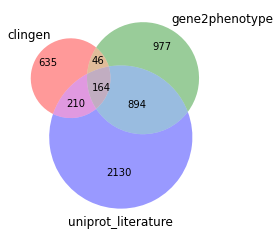

In [103]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

merged_literature['association'] = merged_literature.apply(lambda x: f'{x["target"]}-{x["disease"]}', axis=1)

# venn2([set1, set2], ('Set1', 'Set2')) # venn2 works for two sets
venn3([set(merged_literature.loc[merged_literature.source_x == 'clingen','association'].to_list()),
      set(merged_literature.loc[merged_literature.source_y == 'gene2phenotype','association'].to_list()),
       set(merged_literature.loc[merged_literature.source == 'uniprot_literature','association'].to_list())
      ], ['clingen','gene2phenotype','uniprot_literature'])   # venn3 works for three sets
plt.show()

In [96]:
merged_literature.loc[merged_literature.source == 'uniprot_literature','association']

6         ENSG00000008311-Orphanet_2203
7         ENSG00000069431-Orphanet_1517
8       ENSG00000101986-Orphanet_139396
9         ENSG00000138075-Orphanet_2882
11      ENSG00000100997-Orphanet_171848
                     ...               
6639                 nan-Orphanet_93437
6640                  nan-MONDO_0012274
6641                   nan-Orphanet_201
6642                  nan-MONDO_0008162
6643                   nan-Orphanet_269
Name: association, Length: 4986, dtype: object

In [98]:
uniprot_merged_df.loc[uniprot_merged_df.id.isna()]

,uniprot_id,disease,source,data_type,references,variant,id,uniprot_ids
351,Q9UMZ3,Orphanet_90636,uniprot_literature,genetic_literature,"{20346435, 20472657}",,NaN,NaN
352,Q9UMZ3,Orphanet_90635,uniprot_literature,genetic_literature,{29309402},,NaN,NaN
1042,Q9BYB0,Orphanet_48652,uniprot_literature,genetic_literature,"{22892527, 23758760, 24132240}",,NaN,NaN
1043,Q9BYB0,Orphanet_48652,uniprot,genetic_association,{22892527},rs397514705,NaN,NaN
1044,Q9BYB0,EFO_0000692,uniprot,genetic_association,{20385823},rs387906933,NaN,NaN
2112,Q156A1,Orphanet_98760,uniprot_literature,genetic_literature,{16804541},,NaN,NaN
3790,P49639,Orphanet_69737,uniprot_literature,genetic_literature,{16155570},,NaN,NaN
3791,P49639,Orphanet_69739,uniprot_literature,genetic_literature,{16155570},,NaN,NaN
9681,Q63HN8,Orphanet_2573,uniprot_literature,genetic_literature,"{25956231, 23110205, 26198278, 27736983, 21799...",,NaN,NaN
9682,Q63HN8,Orphanet_2573,uniprot,genetic_association,"{23110205, 21048783}",rs148731719,NaN,NaN


In [1]:
__name__

'__main__'

In [90]:
merged_literature.head()

,target,disease,source_x,source_y,id,source
0,ENSG00000166535,Orphanet_500,clingen,NaN,NaN,NaN
1,ENSG00000166535,Orphanet_1340,clingen,NaN,NaN,NaN
2,ENSG00000166535,Orphanet_3071,clingen,NaN,NaN,NaN
3,ENSG00000166535,Orphanet_648,clingen,NaN,NaN,NaN
4,ENSG00000166535,Orphanet_2701,clingen,NaN,NaN,NaN


In [83]:
merged_literature.loc[merged_literature.source_x == 'gene2phenotype','association'].to_list()

['ENSG00000215612-Orphanet_157962',
 'ENSG00000196924-Orphanet_90650',
 'ENSG00000188827-Orphanet_84',
 'ENSG00000118520-Orphanet_90',
 'ENSG00000148606-Orphanet_137639',
 'ENSG00000086848-Orphanet_79328',
 'ENSG00000198400-Orphanet_642',
 'ENSG00000137693-Orphanet_1473',
 'ENSG00000075891-Orphanet_1475',
 'ENSG00000165671-Orphanet_3447',
 'ENSG00000160710-Orphanet_41',
 'ENSG00000235718-EFO_0005569',
 'ENSG00000128610-MONDO_0018555',
 'ENSG00000136068-Orphanet_3275',
 'ENSG00000115275-Orphanet_137',
 'ENSG00000018510-Orphanet_309803',
 'ENSG00000046651-Orphanet_2750',
 'ENSG00000007168-Orphanet_95232',
 'ENSG00000171735-Orphanet_314647',
 'ENSG00000122863-Orphanet_263463',
 'ENSG00000174775-Orphanet_3071',
 'ENSG00000092200-Orphanet_65',
 'ENSG00000183421-Orphanet_1234',
 'ENSG00000136492-Orphanet_84',
 'ENSG00000046651-Orphanet_373',
 'ENSG00000135111-Orphanet_3138',
 'ENSG00000147475-Orphanet_88616',
 'ENSG00000175198-Orphanet_35',
 'ENSG00000014919-EFO_0009135',
 'ENSG00000168434-O